In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPRegressor, BernoulliRBM
warnings.filterwarnings("ignore")

In [2]:
seinfeld = pd.read_csv('seinfeld episode rankings.csv')

In [3]:
seinfeld

,Title,Plot,Quotability/cultural impact,Laughs,Total score,IMDb rating,IMDb rank,Notes,Season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
seinfeld.columns=['title','plot','quotability','laughs','total_score','imdb_rating','imdb_rank','notes','season','episode']

In [5]:
#seinfeld=seinfeld[seinfeld.season<7]

In [6]:
seinfeld.sort_values('total_score',ascending=False)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
77,the_marine_biologist,5.0,9.0,52.0,101.739130,9.2,5.0,NaN,5.0,14.0
83,the_hamptons,5.0,9.0,48.0,93.913043,8.9,10.0,"""Shrinkage""",5.0,20.0
50,the_contest,5.0,10.0,31.0,67.391304,9.6,1.0,first appearance of Estelle.,4.0,11.0
74,the_conversion,5.0,9.0,30.0,58.695652,8.1,112.0,NaN,5.0,11.0
84,the_opposite,4.0,9.0,31.5,49.304348,9.6,1.0,NaN,5.0,21.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
scripts = pd.read_csv('seinfeld_data/scripts.csv')

In [8]:
episodes = pd.read_csv('seinfeld_data/episode_info.csv')

In [9]:
episodes = episodes.drop(columns='Unnamed: 0')

In [10]:
episodes.Title = episodes.Title.astype(str)

In [11]:
episodes.Title = episodes.Title.str.lower().str.replace(' ','_').str.replace(',','')

In [12]:
scripts = scripts.drop(columns='Unnamed: 0')

In [13]:
scripts[0:211].SEID = 'S01E00'
scripts[0:211].EpisodeNo = 0.0

In [14]:
scripts['line']=scripts.Character.str.strip() +': ' + scripts.Dialogue.str.strip()

In [15]:
episodes.SEID[0] = 'S01E00'
episodes.EpisodeNo[0] = 0.0

In [16]:
scripts

,Character,Dialogue,EpisodeNo,SEID,Season,line
0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0,JERRY: Do you know what this is all about? Do ...
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0,"JERRY: (pointing at Georges shirt) See, to me,..."
2,GEORGE,Are you through?,0.0,S01E00,1.0,GEORGE: Are you through?
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0,"JERRY: You do of course try on, when you buy?"
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0,"GEORGE: Yes, it was purple, I liked it, I dont..."
...,...,...,...,...,...,...
54611,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,S09E23,9.0,JERRY: Grand theft auto - don't steal any of m...
54612,PRISONER 3,You suck - I'm gonna cut you.,23.0,S09E23,9.0,PRISONER 3: You suck - I'm gonna cut you.
54613,JERRY,"Hey, I don't come down to where you work, and ...",23.0,S09E23,9.0,"JERRY: Hey, I don't come down to where you wor..."
54614,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,S09E23,9.0,"GUARD: Alright, Seinfeld, that's it. Let's go...."


In [17]:
scripts[scripts.SEID=='S01E00']

,Character,Dialogue,EpisodeNo,SEID,Season,line
0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0,JERRY: Do you know what this is all about? Do ...
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0,"JERRY: (pointing at Georges shirt) See, to me,..."
2,GEORGE,Are you through?,0.0,S01E00,1.0,GEORGE: Are you through?
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0,"JERRY: You do of course try on, when you buy?"
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0,"GEORGE: Yes, it was purple, I liked it, I dont..."
...,...,...,...,...,...,...
206,LAURA,"Yeah, yeah, hes a great guy...",0.0,S01E00,1.0,"LAURA: Yeah, yeah, hes a great guy..."
207,JERRY,Yeah.,0.0,S01E00,1.0,JERRY: Yeah.
208,LAURA,"Youd really like him, you know, I cant wait to...",0.0,S01E00,1.0,"LAURA: Youd really like him, you know, I cant ..."
209,JERRY,Me too!,0.0,S01E00,1.0,JERRY: Me too!


In [18]:
scripts.Character=scripts.Character.str.replace(r"\(.*\)","")

In [19]:
line_count=scripts.Character.value_counts().head(475)

In [20]:
scripts.Character.str.strip().value_counts().head(10)

JERRY       14905
GEORGE       9781
ELAINE       8073
KRAMER       6723
NEWMAN        649
MORTY         507
HELEN         474
FRANK         438
SUSAN         382
[Setting      293
Name: Character, dtype: int64

In [21]:
episodes["SEID"] = episodes.SEID.astype(str)
scripts["SEID"] = scripts.SEID.astype(str)

In [22]:
scripts[scripts.SEID=='S01E04']

,Character,Dialogue,EpisodeNo,SEID,Season,line
1078,JERRY,Went out to dinner the other night. Check came...,4.0,S01E04,1.0,JERRY: Went out to dinner the other night. Che...
1079,JERRY,I think Superman probably has a very good sens...,4.0,S01E04,1.0,JERRY: I think Superman probably has a very go...
1080,GEORGE,I never heard him say anything really funny.,4.0,S01E04,1.0,GEORGE: I never heard him say anything really ...
1081,JERRY,"But its common sense. Hes got super strength, ...",4.0,S01E04,1.0,JERRY: But its common sense. Hes got super str...
1082,GEORGE,"You would think that, but either youre born wi...",4.0,S01E04,1.0,"GEORGE: You would think that, but either youre..."
...,...,...,...,...,...,...
1303,JERRY,We went over that.,4.0,S01E04,1.0,JERRY: We went over that.
1304,GEORGE,Pst. (moves in close with Elaine and Jerry) Wi...,4.0,S01E04,1.0,GEORGE: Pst. (moves in close with Elaine and J...
1305,JERRY,A robot butcher?,4.0,S01E04,1.0,JERRY: A robot butcher?
1306,GEORGE,"Shhhhh. If you want to get in, theres very lit...",4.0,S01E04,1.0,"GEORGE: Shhhhh. If you want to get in, theres ..."


In [23]:
pd.merge(episodes, right=scripts, on='SEID')

,Season_x,EpisodeNo_x,Title,AirDate,Writers,Director,SEID,Character,Dialogue,EpisodeNo_y,Season_y,line
0,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,JERRY,Do you know what this is all about? Do you kno...,0.0,1.0,JERRY: Do you know what this is all about? Do ...
1,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,1.0,"JERRY: (pointing at Georges shirt) See, to me,..."
2,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,GEORGE,Are you through?,0.0,1.0,GEORGE: Are you through?
3,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,JERRY,"You do of course try on, when you buy?",0.0,1.0,"JERRY: You do of course try on, when you buy?"
4,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,1.0,"GEORGE: Yes, it was purple, I liked it, I dont..."
...,...,...,...,...,...,...,...,...,...,...,...,...
54611,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,9.0,JERRY: Grand theft auto - don't steal any of m...
54612,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,PRISONER 3,You suck - I'm gonna cut you.,23.0,9.0,PRISONER 3: You suck - I'm gonna cut you.
54613,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,"Hey, I don't come down to where you work, and ...",23.0,9.0,"JERRY: Hey, I don't come down to where you wor..."
54614,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,9.0,"GUARD: Alright, Seinfeld, that's it. Let's go...."


In [24]:
seinfeld.title[0] = 'good_news_bad_news'

In [25]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
episodes.columns = episodes.columns.str.lower()


In [28]:
seinfeld.title = seinfeld.title.str.replace(r"\d:\d*","").str.strip().str.replace(' ','_').str.lower()

In [29]:
seinfeld[seinfeld.title=="the_cafe"]

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
23,the_cafe,4.0,6.0,9.5,9.913043,8.4,58.0,Babu’s first appearance,3.0,7.0


In [30]:
episodes[episodes.title=='the_cafe']

,season,episodeno,title,airdate,writers,director,seid
23,3.0,7.0,the_cafe,"November 6, 1991",Tom Leopold,Tom Cherones,S03E07


In [31]:
episodes.title.to_csv('titles.csv')

In [32]:
seinfeld=pd.merge(seinfeld, right = episodes, on='title')

In [33]:
seinfeld.sort_values('total_score',ascending=True).head(10)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid
173,the_finale,NaN,NaN,NaN,0.0,7.8,158.0,NaN,9.0,21.0,9.0,23.0,"May 14, 1998",Larry David,Andy Ackerman,S09E23
120,the_cadillac_(1),NaN,NaN,NaN,0.0,8.5,49.0,NaN,7.0,14.0,7.0,14.0,"February 8, 1996","Larry David, Jerry Seinfeld",Andy Ackerman,S07E14
121,the_cadillac_(2),NaN,NaN,NaN,0.0,8.5,49.0,NaN,7.0,15.0,7.0,15.0,"February 8, 1996","Larry David, Jerry Seinfeld",Andy Ackerman,S07E15
122,the_shower_head,NaN,NaN,NaN,0.0,8.4,58.0,NaN,7.0,16.0,7.0,16.0,"February 15, 1996","Peter Mehlman, Marjorie Gross",Andy Ackerman,S07E16
123,the_doll,NaN,NaN,NaN,0.0,8.1,112.0,NaN,7.0,17.0,7.0,17.0,"February 22, 1996","Tom Gammill, Max Pross",Andy Ackerman,S07E17
124,the_friars_club_(a.k.a._the_gypsies),NaN,NaN,NaN,0.0,7.7,160.0,NaN,7.0,18.0,7.0,18.0,"March 7, 1996",David Mandel,Andy Ackerman,S07E18
125,the_wig_master,NaN,NaN,NaN,0.0,8.1,112.0,NaN,7.0,19.0,7.0,19.0,"April 4, 1996",Spike Feresten,Andy Ackerman,S07E19
126,the_calzone,NaN,NaN,NaN,0.0,8.7,24.0,NaN,7.0,20.0,7.0,20.0,"April 25, 1996","Alec Berg, Jeff Schaffer",Andy Ackerman,S07E20
127,the_bottle_deposit_(1),NaN,NaN,NaN,0.0,8.6,35.0,NaN,7.0,21.0,7.0,21.0,"May 2, 1996","Gregg Kavet, Andy Robin",Andy Ackerman,S07E21
128,the_bottle_deposit_(2),NaN,NaN,NaN,0.0,8.6,35.0,NaN,7.0,22.0,7.0,22.0,"May 2, 1996","Gregg Kavet, Andy Robin",Andy Ackerman,S07E22


In [34]:
seinfeld.director = seinfeld.director.replace('David&nbsp; Steinberg','David Steinberg')

In [35]:
seinfeld.director.value_counts()

Andy Ackerman         87
Tom Cherones          80
David Steinberg        2
David Owen Trainor     2
Art Wolff              1
Joshua White           1
Jason Alexander        1
Name: director, dtype: int64

In [36]:
scripts.Character = scripts.Character.str.strip()
scripts.Character = scripts.Character.replace(r'babu.*|BABU.*','BABU')

In [37]:
scripts.Character.nunique()

1214

In [38]:
scripts=scripts[~scripts.Character.str.contains(r'\(\*|[a-z]|http')]

In [39]:
#scripts = scripts.drop(index=scripts[(scripts.Character==r'http')|(scripts.Dialogue.isnull())].index.tolist())
grouped_scripts=scripts.groupby('SEID')

In [40]:
for key, item in grouped_scripts:
    print(grouped_scripts.get_group(key), "\n\n")

    Character                                           Dialogue  EpisodeNo  \
0       JERRY  Do you know what this is all about? Do you kno...        0.0   
1       JERRY  (pointing at Georges shirt) See, to me, that b...        0.0   
2      GEORGE                                   Are you through?        0.0   
3       JERRY             You do of course try on, when you buy?        0.0   
4      GEORGE  Yes, it was purple, I liked it, I dont actuall...        0.0   
..        ...                                                ...        ...   
206     LAURA                     Yeah, yeah, hes a great guy...        0.0   
207     JERRY                                              Yeah.        0.0   
208     LAURA  Youd really like him, you know, I cant wait to...        0.0   
209     JERRY                                            Me too!        0.0   
210     JERRY  I swear, I have absolutely no idea what women ...        0.0   

       SEID  Season                                

[345 rows x 6 columns] 


      Character                                           Dialogue  EpisodeNo  \
22729     JERRY  I love these nature shows, Ill watch and kind ...       14.0   
22730    ELAINE  (to the phone) Well did he bring it up in the ...       14.0   
22731     JERRY  Elaine, see this T-shirt, six years I've had t...       14.0   
22732    ELAINE                       Yeah, I'm on the phone here.       14.0   
22733     JERRY  Golden Boys always the first shirt I wear out ...       14.0   
...         ...                                                ...        ...   
23075    ELAINE                   I'm sorry. (pats him on the arm)       14.0   
23076     JERRY  Yea. (pulls at the t-shirt) This is Golden Boy...       14.0   
23077    KRAMER                       (to George) What's with you?       14.0   
23078    GEORGE                              Sand. It's everywhere       14.0   
23079    KRAMER                                               Yep.       14.0   

 

[320 rows x 6 columns] 


      Character                                           Dialogue  EpisodeNo  \
48935     JERRY  I just think if you borrow my blender you shou...        6.0   
48936    KRAMER  Well whats the difference -- Come on (pats him...        6.0   
48937     JERRY                      Yeah, ya know Cain slew Able.        6.0   
48938    KRAMER  No he didnt. They were in business together it...        6.0   
48939     JERRY                                            Oh, no.        6.0   
...         ...                                                ...        ...   
49228    GEORGE  So go ahead pigeons. hu hu hu. Laugh it up. I'...        6.0   
49229     CELIA  I'm glad you called, Elaine. I really needed t...        6.0   
49230    ELAINE  Oh well, hey, I dated Jerry too. I-I know what...        6.0   
49231     CELIA                                    Who's he? (Lou)        6.0   
49232    ELAINE  Oh, he's nobody. Hey, listen, ... let me top t...        6.0   

 

In [41]:
seinfeld.writers.value_counts()

Larry David                                                                                                                                              29
Larry David, Jerry Seinfeld                                                                                                                              15
Larry Charles                                                                                                                                            15
Peter Mehlman                                                                                                                                            14
Gregg Kavet, Andy Robin                                                                                                                                  10
Tom Gammill, Max Pross                                                                                                                                   10
Alec Berg, Jeff Schaffer                                        

In [42]:
scripts = scripts.drop(index=scripts[scripts.Character=='http'].index.tolist())

In [43]:
for Character, Dialogue in grouped_scripts:
    #print(f'{SEID}')
    print('--------')
    print(f'{Character}: {Dialogue}')

--------
S01E00:     Character                                           Dialogue  EpisodeNo  \
0       JERRY  Do you know what this is all about? Do you kno...        0.0   
1       JERRY  (pointing at Georges shirt) See, to me, that b...        0.0   
2      GEORGE                                   Are you through?        0.0   
3       JERRY             You do of course try on, when you buy?        0.0   
4      GEORGE  Yes, it was purple, I liked it, I dont actuall...        0.0   
..        ...                                                ...        ...   
206     LAURA                     Yeah, yeah, hes a great guy...        0.0   
207     JERRY                                              Yeah.        0.0   
208     LAURA  Youd really like him, you know, I cant wait to...        0.0   
209     JERRY                                            Me too!        0.0   
210     JERRY  I swear, I have absolutely no idea what women ...        0.0   

       SEID  Season               

[372 rows x 6 columns]
--------
S04E21:          Character                                           Dialogue  \
17298        JERRY  ...And it *is* embarrassing, because a doggie ...   
17299        JERRY                             Is that bothering you?   
17300       ELAINE                                  No, not at all...   
17301       ELAINE                        Oh, could you please hurry?   
17302        JERRY  [mockingly] "Please hurry". Look at you. Look ...   
...            ...                                                ...   
17531        JERRY  Wait a second... My jacket! I wore that in the...   
17532     SALESMAN                             I can't sell this car.   
17533        JERRY        This... **thing**... has got to be stopped!   
17534  HAIRDRESSER                        So, what do you want to do?   
17535       ELAINE                                          Sauce me.   

       EpisodeNo    SEID  Season  \
17298       21.0  S04E21     4.0   
17299      

[294 rows x 6 columns]
--------
S05E21:       Character                                           Dialogue  EpisodeNo  \
25101    KRAMER               All right, get off at the next exit.       21.0   
25102     JERRY  Kramer, I've driven to east Hampton many times...       21.0   
25103    KRAMER  It's a great house, pool, sun deck? Yeah, I'll...       21.0   
25104     JERRY  (To Elaine) You sure we're makin' the right move?       21.0   
25105    ELAINE  We gotta see the new baby anyway, at least we'...       21.0   
...         ...                                                ...        ...   
25410     JERRY                     They got some sort of program.       21.0   
25411    GEORGE  Hey, there's a tomato stand, let's stop, I can...       21.0   
25412     JERRY                     Hey, isn't that Michael's car?       21.0   
25413    ELAINE                                    There's Rachel.       21.0   
25414    GEORGE  Where? (He looks out window and gets hit by a ...   

[357 rows x 6 columns]
--------
S08E08:       Character                                           Dialogue  EpisodeNo  \
42623    GEORGE  Dollar Eighty-Nine. Why is this a dollar eight...        8.0   
42624     JERRY  I guess we like to think we've progressed beyo...        8.0   
42625    GEORGE  Not me. Everything should be negotiable. (he p...        8.0   
42626     JERRY                                   Restaurants too?        8.0   
42627    GEORGE  Absolutely. You're telling me there's no room ...        8.0   
...         ...                                                ...        ...   
42934     JERRY             Home at last. Ahhhh. (light turns off)        8.0   
42935     JERRY                                  Is someone there?        8.0   
42936     JERRY                                       Mr. Marbles?        8.0   
42937    ELAINE  This the Urban Sombrero, I put it on the last ...        8.0   
42938  PETERMAN                         The horror ... the horror.   

S09E14:       Character                                           Dialogue  EpisodeNo  \
51657    GEORGE  (clears throat) Maura, I, uh- I want you to kn...       14.0   
51658     MAURA                               No. (sips her drink)       14.0   
51659    GEORGE                        (double takes) What's that?       14.0   
51660     MAURA         We're not breaking up. (takes another sip)       14.0   
51661    GEORGE                             (puzzled) W-we're not?       14.0   
...         ...                                                ...        ...   
51990     JERRY  (still in tuxedo, tie undone) Ah, I'll just ta...       14.0   
51991    GEORGE     So, what's in the cooler? (flips open the lid)       14.0   
51992    KRAMER  Oh. Well, would you look at that. (puts a gun-...       14.0   
51993     JERRY  You mean it was open? We desecrated a pet ceme...       14.0   
51994    KRAMER  Well, this is one for the books, huh, Jerry?.....       14.0   

         SEID  Seas

In [44]:
import dask.dataframe as dd

In [45]:
scripts_dd=dd.from_pandas(scripts,npartitions=54615)

In [46]:
scripts_dd

,Character,Dialogue,EpisodeNo,SEID,Season,line
npartitions=53961,,,,,,
0,object,object,float64,object,float64,object
1,...,...,...,...,...,...
...,...,...,...,...,...,...
54614,...,...,...,...,...,...
54615,...,...,...,...,...,...


In [47]:
seinfeld_prepped=seinfeld.drop(columns=['season_x','episode','notes','title','seid'])

In [48]:
#seinfeld_prepped.airdate=pd.to_datetime(seinfeld_prepped.airdate)
#seinfeld_prepped = seinfeld_prepped.set_index('airdate').sort_values(by='airdate')

In [49]:
seinfeld_prepped = pd.get_dummies(seinfeld_prepped, columns=['writers','director'], drop_first=True)

In [50]:
train=seinfeld_prepped[seinfeld_prepped.season_y<4]
validate=seinfeld_prepped[seinfeld_prepped.season_y>3]

In [51]:
def get_script():
    for i in seinfeld.seid.to_list():
        for episode in scripts.SEID.to_list():
            script=f'TITLE: {i}\n'
            if str(scripts.SEID) == str(i):
                script += f'{scripts.Character}: {scripts.Dialogue}'
            else:
                continue
        return(script)

In [52]:
start = scripts.index[scripts.SEID=='S01E00'][0]
end = scripts.index[scripts.SEID=='S01E00'][-1] +1

In [53]:
train

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,airdate,"writers_Alec Berg, Jeff Schaffer",...,"writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_Art Wolff,director_David Owen Trainor,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
0,4.0,7.0,7.0,8.521739,7.6,166.0,1.0,0.0,"July 5, 1989",0,...,0,0,0,0,1,0,0,0,0,0
1,3.0,6.5,2.0,1.695652,7.3,173.0,1.0,3.0,"June 14, 1990",0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,7.0,9.0,10.956522,7.7,160.0,1.0,1.0,"May 31, 1990",0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,3.5,5.5,2.510870,7.6,166.0,1.0,2.0,"June 7, 1990",0,...,0,0,0,0,0,0,0,0,0,1
4,3.0,3.0,6.5,2.543478,7.5,168.0,1.0,4.0,"June 21, 1990",0,...,0,0,0,0,0,0,0,0,0,1
5,3.0,5.0,7.5,4.891304,7.7,160.0,2.0,1.0,"January 16, 1991",0,...,0,0,0,0,0,0,0,0,0,1
6,4.0,5.0,8.0,6.956522,7.9,149.0,2.0,2.0,"January 30, 1991",0,...,0,0,0,0,0,0,0,0,0,1
7,5.0,6.0,8.5,11.086957,8.3,79.0,2.0,3.0,"February 6, 1991",0,...,0,0,0,0,0,0,0,0,0,1
8,4.0,3.0,13.5,7.043478,8.4,58.0,2.0,4.0,"February 13, 1991",0,...,0,0,0,0,0,0,0,0,0,1
9,2.0,7.0,9.5,5.782609,7.9,149.0,2.0,5.0,"April 4, 1991",0,...,0,0,0,0,0,0,0,0,0,1


In [54]:
x_train = train.drop(columns=['plot','quotability','laughs','total_score','airdate'])
y_train = train.total_score
x_validate = validate.drop(columns=['plot','quotability','laughs','total_score','airdate'])
y_validate = validate.total_score

In [55]:
regr = MLPRegressor( max_iter=1500).fit(x_train, y_train)

In [56]:
predictions=pd.DataFrame(regr.predict(x_validate),columns=['predict'])
regr.score(x_validate,y_validate)

-0.7470341626016712

In [57]:
y_validate=pd.concat([y_validate.reset_index(),predictions],axis=1)

<AxesSubplot:>

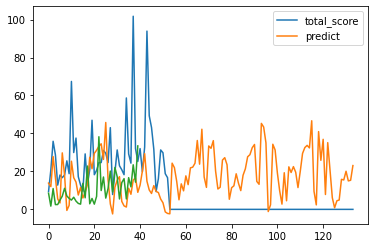

In [58]:
y_validate.drop(columns='index').plot()
y_train.plot()

<AxesSubplot:>

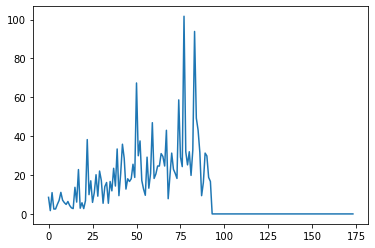

In [59]:
seinfeld.total_score.plot()

In [60]:
seinfeld_prepped.airdate = pd.to_datetime(seinfeld_prepped.airdate)
x=seinfeld_prepped.drop(columns=['plot','quotability','laughs','total_score']).set_index('airdate')
x_train = seinfeld_prepped.drop(columns=['plot','quotability','laughs','total_score'])[seinfeld_prepped.total_score > 0].set_index('airdate')
y_train = seinfeld_prepped.total_score[seinfeld_prepped.total_score > 0]
regr = MLPRegressor( max_iter=750,solver= 'lbfgs').fit(x_train,y_train)
mlp_predictions=pd.DataFrame(regr.predict(x),columns=['predict'])
y_mlp=pd.concat([y_train,mlp_predictions],axis=1)

<AxesSubplot:>

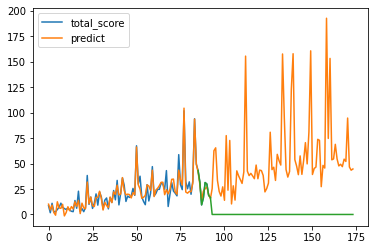

In [61]:
y_mlp.plot()
seinfeld[seinfeld.season_y > 5].total_score.plot()


In [62]:
seinfeld_prepped.corr()

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,"writers_Alec Berg, Jeff Schaffer","writers_Alec Berg, Jeff Schaffer, David Mandel",...,"writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_Art Wolff,director_David Owen Trainor,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
plot,1.000000,0.386734,0.362707,0.573158,0.373140,-0.366608,0.257786,-0.000114,0.032428,NaN,...,-0.051224,NaN,-0.104652,-0.051351,0.032428,NaN,-0.051351,-0.104652,-0.104652,-0.003069
quotability,0.386734,1.000000,0.533961,0.652910,0.413787,-0.382166,0.525411,0.296171,0.003911,NaN,...,0.085709,NaN,0.059872,-0.153587,0.003911,NaN,-0.153587,0.003911,0.003911,0.034809
laughs,0.362707,0.533961,1.000000,0.904011,0.529911,-0.473255,0.555470,0.343825,0.098491,NaN,...,0.004719,NaN,0.263271,-0.111609,-0.115112,-0.163936,-0.098593,-0.041877,-0.109009,0.081009
total_score,0.573158,0.652910,0.904011,1.000000,0.219621,-0.153522,-0.375651,0.028441,-0.113348,-0.074164,...,-0.017484,-0.052290,0.039787,-0.023473,-0.012713,-0.074164,-0.008365,0.002835,-0.020487,0.573521
imdb_rating,0.373140,0.413787,0.529911,0.219621,1.000000,-0.956025,0.225811,0.165351,0.045695,0.021098,...,-0.023232,0.106660,-0.003481,-0.096063,-0.131979,-0.004938,-0.017956,-0.058552,0.051589,-0.106283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
director_David Owen Trainor,NaN,NaN,-0.163936,-0.074164,-0.004938,-0.001307,0.069013,-0.003760,-0.025184,-0.011628,...,-0.026627,-0.008198,-0.008198,-0.011628,-0.008198,1.000000,-0.011628,-0.008198,-0.008198,-0.099479
director_David Steinberg,-0.051351,-0.153587,-0.098593,-0.008365,-0.017956,0.021429,-0.120094,-0.099506,-0.025184,-0.011628,...,-0.026627,-0.008198,-0.008198,-0.011628,-0.008198,-0.011628,1.000000,-0.008198,-0.008198,-0.099479
director_Jason Alexander,-0.104652,0.003911,-0.041877,0.002835,-0.058552,0.082283,-0.084674,0.098609,-0.017756,-0.008198,...,-0.018774,-0.005780,-0.005780,-0.008198,-0.005780,-0.008198,-0.008198,1.000000,-0.005780,-0.070139
director_Joshua White,-0.104652,0.003911,-0.109009,-0.020487,0.051589,-0.070385,-0.084674,-0.070158,-0.017756,-0.008198,...,-0.018774,-0.005780,-0.005780,-0.008198,-0.005780,-0.008198,-0.008198,-0.005780,1.000000,-0.070139


In [63]:
grouped_scripts.Character.value_counts()/len(grouped_scripts.Character.sum())

SEID    Character 
S01E00  JERRY         0.540230
        GEORGE        0.402299
        KESSLER       0.114943
        LAURA         0.086207
        CLAIRE        0.040230
                        ...   
S09E23  PROSTITUTE    0.005747
        PUDDY         0.005747
        SECRETARY     0.005747
        STRANGER      0.005747
        SUSAN         0.005747
Name: Character, Length: 2634, dtype: float64

In [64]:
scripts['line']=scripts.Character.str.strip() +': ' + scripts.Dialogue.str.strip()

In [65]:
seinfeld['script'] = scripts.groupby('SEID').line
seinfeld.script = seinfeld.script.astype(str)

In [66]:
seinfeld.script = seinfeld.script.str.replace(r"(S\d+E\d+|,\s\d*\s{2,}|Name:.*)|\(\'|(?<=\n)\d+","")

In [67]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid,script
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0,1.0,0.0,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,'JERRY: Do you know what this is all about? Do...
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03,"'JERRY: So, Im on line at the supermarket. Two..."
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0,1.0,1.0,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,"'JERRY: So I move into the centre lane, now I ..."
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02,'JERRY: Most men like working on things. Tools...
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04,'JERRY: Went out to dinner the other night. Ch...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,the_bookstore,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,9.0,17.0,9.0,17.0,"April 9, 1998",Spike Feresten,Andy Ackerman,S09E17,'GEORGE: I read somewhere that this Brentano's...
170,the_frogger,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,9.0,18.0,9.0,18.0,"April 23, 1998","Gregg Kavet, Andy Robin",Andy Ackerman,S09E18,'ALL: Happy birthday to you.\n ...
171,the_maid,NaN,NaN,NaN,0.000000,8.0,135.0,NaN,9.0,19.0,9.0,19.0,"April 30, 1998","Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,S09E19,'JERRY: Cup of tea with lemon.\n ...
172,the_puerto_rican_day,NaN,NaN,NaN,0.000000,7.9,149.0,NaN,9.0,20.0,9.0,20.0,"May 7, 1998","Alec Berg, Jennifer Crittenden, Spike Feresten...",Andy Ackerman,S09E20,"'GEORGE: Man, I'm starving.\n ELAINE: How c..."


In [68]:
class lemmatizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, df):
        return [self.wnl.lemmatize(word) for word in word_tokenize(df)]

vectorizer = CountVectorizer( max_df=0.95, min_df=0.05, ngram_range=(1,2),
                             tokenizer=lemmatizer(), lowercase=True, stop_words='english',
                             token_pattern = r'\w+')

vectorizer.fit(seinfeld['script'])
count_vector = vectorizer.transform(seinfeld['script'])

bow_data = count_vector.toarray()
bow_data = pd.DataFrame(bow_data, columns=vectorizer.get_feature_names())
bow_data.head()

,!,! !,! (,! ...,! george,! jerry,','d,'elaine,'elaine :,...,woman,y,y ...,ya,yeah,"yeah ,",yeah .,yes,yo,yo ...
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,3,2,1,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid,script
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0,1.0,0.0,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,'JERRY: Do you know what this is all about? Do...
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03,"'JERRY: So, Im on line at the supermarket. Two..."
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0,1.0,1.0,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,"'JERRY: So I move into the centre lane, now I ..."
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02,'JERRY: Most men like working on things. Tools...
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04,'JERRY: Went out to dinner the other night. Ch...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,the_bookstore,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,9.0,17.0,9.0,17.0,"April 9, 1998",Spike Feresten,Andy Ackerman,S09E17,'GEORGE: I read somewhere that this Brentano's...
170,the_frogger,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,9.0,18.0,9.0,18.0,"April 23, 1998","Gregg Kavet, Andy Robin",Andy Ackerman,S09E18,'ALL: Happy birthday to you.\n ...
171,the_maid,NaN,NaN,NaN,0.000000,8.0,135.0,NaN,9.0,19.0,9.0,19.0,"April 30, 1998","Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,S09E19,'JERRY: Cup of tea with lemon.\n ...
172,the_puerto_rican_day,NaN,NaN,NaN,0.000000,7.9,149.0,NaN,9.0,20.0,9.0,20.0,"May 7, 1998","Alec Berg, Jennifer Crittenden, Spike Feresten...",Andy Ackerman,S09E20,"'GEORGE: Man, I'm starving.\n ELAINE: How c..."


In [70]:
x_train, x_test, y_train, y_test = train_test_split(bow_data,
                                                  seinfeld['total_score'],
                                                  test_size=0.2, random_state=123)

In [71]:
train=seinfeld[seinfeld.season_x<6].total_score

In [72]:
regr = MLPRegressor( max_iter=100,solver= 'lbfgs').fit(bow_data[:85],train)
mlp_predictions=pd.DataFrame(regr.predict(bow_data),columns=['predict'])
y_mlp=pd.concat([train,mlp_predictions],axis=1)

<AxesSubplot:>

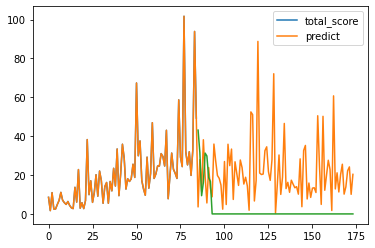

In [73]:
y_mlp.plot()
seinfeld[seinfeld.season_y > 5].total_score.plot()

In [74]:
mean_squared_error(train,y_mlp.predict[:85])

1.9206598592692063e-08

In [75]:
#y_mlp.total_score = y_mlp.total_score.replace(np.NaN, 0)

In [76]:
y_mlp.total_score.isna().sum()

89

<AxesSubplot:>

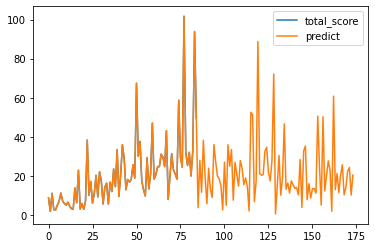

In [77]:
y_mlp.plot()

In [78]:
y_mlp.head(50)

,total_score,predict
0,8.521739,8.521853
1,1.695652,1.695833
2,10.956522,10.956809
3,2.510870,2.511029
4,2.543478,2.543047
5,4.891304,4.891114
6,6.956522,6.956606
7,11.086957,11.086998
8,7.043478,7.043833
9,5.782609,5.782680


In [81]:
seinfeld.script.to_csv('seinfeld_scripts.csv')

In [88]:
scripts

,Character,Dialogue,EpisodeNo,SEID,Season,line
0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0,JERRY: Do you know what this is all about? Do ...
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0,"JERRY: (pointing at Georges shirt) See, to me,..."
2,GEORGE,Are you through?,0.0,S01E00,1.0,GEORGE: Are you through?
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0,"JERRY: You do of course try on, when you buy?"
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0,"GEORGE: Yes, it was purple, I liked it, I dont..."
...,...,...,...,...,...,...
54611,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,S09E23,9.0,JERRY: Grand theft auto - don't steal any of m...
54612,PRISONER 3,You suck - I'm gonna cut you.,23.0,S09E23,9.0,PRISONER 3: You suck - I'm gonna cut you.
54613,JERRY,"Hey, I don't come down to where you work, and ...",23.0,S09E23,9.0,"JERRY: Hey, I don't come down to where you wor..."
54614,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,S09E23,9.0,"GUARD: Alright, Seinfeld, that's it. Let's go...."
